In [1]:
pip install numpy==1.26.4 torch transformers==4.48.2 scikit-learn accelerate==0.26.0 matplotlib tqdm pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os, json, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns, shutil
from tqdm import tqdm

# ========== CONFIG ==========
DATA_DIR = "/workspace/SPLIT_SLIDING_FINAL/train"
OUTPUT_DIR = "/workspace/HASIL_DECODER_KFOLD/Hasil_2"
LABEL_MAP = {'N': 0, 'AFIB': 1, 'VFL': 2}
N_SPLITS = 5
SEED = 42
EPOCHS = 20
BATCH_SIZE = 16
LR = 2e-5
MAX_LEN = 512
D_MODEL = 768
N_HEAD = 12
N_LAYERS = 12

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== DATA LOADING ==========
def load_data(data_dir):
    data, labels = [], []
    for label_name in os.listdir(data_dir):
        if label_name not in LABEL_MAP:
            continue
        folder_path = os.path.join(data_dir, label_name)
        for file in os.listdir(folder_path):
            if file.endswith(".npy"):
                sig = np.load(os.path.join(folder_path, file), allow_pickle=True)
                if isinstance(sig, np.ndarray) and sig.ndim == 1:
                    data.append(sig.astype(np.float32))
                    labels.append(LABEL_MAP[label_name])
    return data, np.array(labels)

X_raw, y = load_data(DATA_DIR)

def signal_to_tensor(sig, target_len=MAX_LEN):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig) - 1, target_len).astype(int)
        sig = sig[idx]
    sig = (sig - sig.min()) / (sig.ptp() + 1e-8)
    return torch.tensor(sig, dtype=torch.float32)

X = [signal_to_tensor(sig) for sig in X_raw]

# ========== DATASET ==========
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

# ========== MODEL (DECODER-ONLY) ==========
class SimpleDecoderOnly(nn.Module):
    def __init__(self, d_model=D_MODEL, nhead=N_HEAD, num_layers=N_LAYERS, num_classes=3):
        super().__init__()
        self.embedding = nn.Linear(MAX_LEN, d_model)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.query = nn.Parameter(torch.randn(1, 1, d_model))
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x.unsqueeze(1))
        tgt = self.query.repeat(x.size(0), 1, 1)
        x = self.decoder(tgt, x)
        x = x.squeeze(1)
        return self.classifier(x)

# ========== METRICS ==========
def specificity_per_class(true, pred, label, num_classes):
    cm = confusion_matrix(true, pred, labels=list(range(num_classes)))
    TN = cm.sum() - (cm[label, :].sum() + cm[:, label].sum() - cm[label, label])
    FP = cm[:, label].sum() - cm[label, label]
    return TN / (TN + FP + 1e-8)

# ========== TRAINING ==========
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
all_results = []
best_f1 = 0
best_fold = 0

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n[INFO] Fold {fold}")
    train_set = ECGDataset([X[i] for i in train_idx], y[train_idx])
    val_set = ECGDataset([X[i] for i in val_idx], y[val_idx])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

    model = SimpleDecoderOnly(num_classes=len(LABEL_MAP)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0
        for xb, yb in tqdm(train_loader, desc=f"Fold {fold} Epoch {epoch}"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Epoch {epoch}] Loss: {total_loss/len(train_loader):.4f}")

    # === EVALUASI ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            out = model(xb)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())

    acc = accuracy_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1s = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    spec = np.mean([specificity_per_class(all_labels, all_preds, i, len(LABEL_MAP)) for i in range(len(LABEL_MAP))])

    fold_dir = os.path.join(OUTPUT_DIR, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(fold_dir, "decoder.pt"))
    torch.save(optimizer.state_dict(), os.path.join(fold_dir, "optimizer.pt"))
    
    # Save config for reproducibility
    config = {
        "d_model": D_MODEL,
        "n_head": N_HEAD,
        "n_layers": N_LAYERS,
        "num_classes": len(LABEL_MAP),
        "max_len": MAX_LEN
    }
    with open(os.path.join(fold_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=2)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
    plt.title(f"Confusion Matrix Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confmat_fold.png"))
    plt.close()

    df_per_class = []
    for idx, label in enumerate(LABEL_MAP):
        mask_true = (np.array(all_labels) == idx).astype(int)
        mask_pred = (np.array(all_preds) == idx).astype(int)
        acc_i = accuracy_score(mask_true, mask_pred)
        rec_i = recall_score(mask_true, mask_pred, zero_division=0)
        f1_i = f1_score(mask_true, mask_pred, zero_division=0)
        spec_i = specificity_per_class(all_labels, all_preds, idx, len(LABEL_MAP))
        df_per_class.append([fold, label, acc_i, rec_i, f1_i, spec_i])

    df_fold = pd.DataFrame(df_per_class, columns=["fold", "kelas", "akurasi", "recall", "f1 score", "spesifisitas"])
    df_fold.to_csv(os.path.join(fold_dir, f"hasil_fold{fold}.csv"), index=False)
    all_results.append(df_fold)

    if f1s > best_f1:
        best_f1 = f1s
        best_fold = fold
        shutil.copyfile(os.path.join(fold_dir, "confmat_fold.png"), os.path.join(OUTPUT_DIR, "confmat_final.png"))
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "decoder_best.pt"))
        with open(os.path.join(OUTPUT_DIR, "config.json"), "w") as f:
            json.dump(config, f, indent=2)

final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv(os.path.join(OUTPUT_DIR, "hasil_kfold_decoder.csv"), index=False)
print(f"[INFO] Fold terbaik berdasarkan F1-score: Fold {best_fold}")



[INFO] Fold 1


Fold 1 Epoch 1: 100%|██████████| 240/240 [00:05<00:00, 41.66it/s]


[Epoch 1] Loss: 0.5514


Fold 1 Epoch 2: 100%|██████████| 240/240 [00:05<00:00, 40.89it/s]


[Epoch 2] Loss: 0.2180


Fold 1 Epoch 3: 100%|██████████| 240/240 [00:05<00:00, 44.01it/s]


[Epoch 3] Loss: 0.1832


Fold 1 Epoch 4: 100%|██████████| 240/240 [00:05<00:00, 46.04it/s]


[Epoch 4] Loss: 0.1505


Fold 1 Epoch 5: 100%|██████████| 240/240 [00:05<00:00, 46.04it/s]


[Epoch 5] Loss: 0.1328


Fold 1 Epoch 6: 100%|██████████| 240/240 [00:05<00:00, 46.68it/s]


[Epoch 6] Loss: 0.1363


Fold 1 Epoch 7: 100%|██████████| 240/240 [00:05<00:00, 46.76it/s]


[Epoch 7] Loss: 0.1067


Fold 1 Epoch 8: 100%|██████████| 240/240 [00:05<00:00, 44.76it/s]


[Epoch 8] Loss: 0.1232


Fold 1 Epoch 9: 100%|██████████| 240/240 [00:05<00:00, 45.15it/s]


[Epoch 9] Loss: 0.0947


Fold 1 Epoch 10: 100%|██████████| 240/240 [00:05<00:00, 43.66it/s]


[Epoch 10] Loss: 0.1280


Fold 1 Epoch 11: 100%|██████████| 240/240 [00:05<00:00, 41.40it/s]


[Epoch 11] Loss: 0.0891


Fold 1 Epoch 12: 100%|██████████| 240/240 [00:05<00:00, 44.03it/s]


[Epoch 12] Loss: 0.1066


Fold 1 Epoch 13: 100%|██████████| 240/240 [00:05<00:00, 43.46it/s]


[Epoch 13] Loss: 0.0848


Fold 1 Epoch 14: 100%|██████████| 240/240 [00:05<00:00, 40.20it/s]


[Epoch 14] Loss: 0.0851


Fold 1 Epoch 15: 100%|██████████| 240/240 [00:05<00:00, 44.04it/s]


[Epoch 15] Loss: 0.0824


Fold 1 Epoch 16: 100%|██████████| 240/240 [00:05<00:00, 42.33it/s]


[Epoch 16] Loss: 0.0764


Fold 1 Epoch 17: 100%|██████████| 240/240 [00:05<00:00, 43.25it/s]


[Epoch 17] Loss: 0.0744


Fold 1 Epoch 18: 100%|██████████| 240/240 [00:05<00:00, 40.80it/s]


[Epoch 18] Loss: 0.0738


Fold 1 Epoch 19: 100%|██████████| 240/240 [00:05<00:00, 43.76it/s]


[Epoch 19] Loss: 0.0579


Fold 1 Epoch 20: 100%|██████████| 240/240 [00:05<00:00, 42.98it/s]


[Epoch 20] Loss: 0.0655

[INFO] Fold 2


Fold 2 Epoch 1: 100%|██████████| 240/240 [00:05<00:00, 43.51it/s]


[Epoch 1] Loss: 0.5515


Fold 2 Epoch 2: 100%|██████████| 240/240 [00:05<00:00, 44.03it/s]


[Epoch 2] Loss: 0.2444


Fold 2 Epoch 3: 100%|██████████| 240/240 [00:05<00:00, 41.81it/s]


[Epoch 3] Loss: 0.1916


Fold 2 Epoch 4: 100%|██████████| 240/240 [00:05<00:00, 40.21it/s]


[Epoch 4] Loss: 0.1617


Fold 2 Epoch 5: 100%|██████████| 240/240 [00:05<00:00, 43.09it/s]


[Epoch 5] Loss: 0.1558


Fold 2 Epoch 6: 100%|██████████| 240/240 [00:05<00:00, 42.58it/s]


[Epoch 6] Loss: 0.1336


Fold 2 Epoch 7: 100%|██████████| 240/240 [00:05<00:00, 41.79it/s]


[Epoch 7] Loss: 0.1439


Fold 2 Epoch 8: 100%|██████████| 240/240 [00:05<00:00, 41.89it/s]


[Epoch 8] Loss: 0.1121


Fold 2 Epoch 9: 100%|██████████| 240/240 [00:05<00:00, 40.69it/s]


[Epoch 9] Loss: 0.1258


Fold 2 Epoch 10: 100%|██████████| 240/240 [00:05<00:00, 40.65it/s]


[Epoch 10] Loss: 0.1068


Fold 2 Epoch 11: 100%|██████████| 240/240 [00:05<00:00, 45.84it/s]


[Epoch 11] Loss: 0.0919


Fold 2 Epoch 12: 100%|██████████| 240/240 [00:05<00:00, 47.96it/s]


[Epoch 12] Loss: 0.0975


Fold 2 Epoch 13: 100%|██████████| 240/240 [00:05<00:00, 46.48it/s]


[Epoch 13] Loss: 0.0875


Fold 2 Epoch 14: 100%|██████████| 240/240 [00:04<00:00, 49.43it/s]


[Epoch 14] Loss: 0.0855


Fold 2 Epoch 15: 100%|██████████| 240/240 [00:04<00:00, 49.78it/s]


[Epoch 15] Loss: 0.0992


Fold 2 Epoch 16: 100%|██████████| 240/240 [00:05<00:00, 45.95it/s]


[Epoch 16] Loss: 0.0797


Fold 2 Epoch 17: 100%|██████████| 240/240 [00:05<00:00, 41.58it/s]


[Epoch 17] Loss: 0.0725


Fold 2 Epoch 18: 100%|██████████| 240/240 [00:05<00:00, 41.46it/s]


[Epoch 18] Loss: 0.0800


Fold 2 Epoch 19: 100%|██████████| 240/240 [00:06<00:00, 38.88it/s]


[Epoch 19] Loss: 0.0711


Fold 2 Epoch 20: 100%|██████████| 240/240 [00:05<00:00, 40.72it/s]


[Epoch 20] Loss: 0.0802

[INFO] Fold 3


Fold 3 Epoch 1: 100%|██████████| 240/240 [00:05<00:00, 43.39it/s]


[Epoch 1] Loss: 0.5590


Fold 3 Epoch 2: 100%|██████████| 240/240 [00:05<00:00, 44.07it/s]


[Epoch 2] Loss: 0.2308


Fold 3 Epoch 3: 100%|██████████| 240/240 [00:05<00:00, 41.68it/s]


[Epoch 3] Loss: 0.1687


Fold 3 Epoch 4: 100%|██████████| 240/240 [00:05<00:00, 43.13it/s]


[Epoch 4] Loss: 0.1837


Fold 3 Epoch 5: 100%|██████████| 240/240 [00:05<00:00, 40.32it/s]


[Epoch 5] Loss: 0.1333


Fold 3 Epoch 6: 100%|██████████| 240/240 [00:05<00:00, 44.16it/s]


[Epoch 6] Loss: 0.1336


Fold 3 Epoch 7: 100%|██████████| 240/240 [00:05<00:00, 42.54it/s]


[Epoch 7] Loss: 0.1344


Fold 3 Epoch 8: 100%|██████████| 240/240 [00:05<00:00, 42.54it/s]


[Epoch 8] Loss: 0.1242


Fold 3 Epoch 9: 100%|██████████| 240/240 [00:05<00:00, 42.93it/s]


[Epoch 9] Loss: 0.1083


Fold 3 Epoch 10: 100%|██████████| 240/240 [00:05<00:00, 42.70it/s]


[Epoch 10] Loss: 0.1112


Fold 3 Epoch 11: 100%|██████████| 240/240 [00:05<00:00, 42.78it/s]


[Epoch 11] Loss: 0.0931


Fold 3 Epoch 12: 100%|██████████| 240/240 [00:05<00:00, 44.96it/s]


[Epoch 12] Loss: 0.1036


Fold 3 Epoch 13: 100%|██████████| 240/240 [00:05<00:00, 45.32it/s]


[Epoch 13] Loss: 0.0988


Fold 3 Epoch 14: 100%|██████████| 240/240 [00:05<00:00, 45.55it/s]


[Epoch 14] Loss: 0.0921


Fold 3 Epoch 15: 100%|██████████| 240/240 [00:05<00:00, 45.82it/s]


[Epoch 15] Loss: 0.1142


Fold 3 Epoch 16: 100%|██████████| 240/240 [00:04<00:00, 48.85it/s]


[Epoch 16] Loss: 0.0849


Fold 3 Epoch 17: 100%|██████████| 240/240 [00:04<00:00, 48.91it/s]


[Epoch 17] Loss: 0.0751


Fold 3 Epoch 18: 100%|██████████| 240/240 [00:04<00:00, 48.61it/s]


[Epoch 18] Loss: 0.0737


Fold 3 Epoch 19: 100%|██████████| 240/240 [00:05<00:00, 42.42it/s]


[Epoch 19] Loss: 0.0748


Fold 3 Epoch 20: 100%|██████████| 240/240 [00:05<00:00, 44.50it/s]


[Epoch 20] Loss: 0.0791

[INFO] Fold 4


Fold 4 Epoch 1: 100%|██████████| 240/240 [00:05<00:00, 42.22it/s]


[Epoch 1] Loss: 0.5913


Fold 4 Epoch 2: 100%|██████████| 240/240 [00:05<00:00, 40.79it/s]


[Epoch 2] Loss: 0.2347


Fold 4 Epoch 3: 100%|██████████| 240/240 [00:05<00:00, 43.76it/s]


[Epoch 3] Loss: 0.1712


Fold 4 Epoch 4: 100%|██████████| 240/240 [00:05<00:00, 44.87it/s]


[Epoch 4] Loss: 0.1490


Fold 4 Epoch 5: 100%|██████████| 240/240 [00:05<00:00, 44.14it/s]


[Epoch 5] Loss: 0.1666


Fold 4 Epoch 6: 100%|██████████| 240/240 [00:05<00:00, 42.05it/s]


[Epoch 6] Loss: 0.1191


Fold 4 Epoch 7: 100%|██████████| 240/240 [00:05<00:00, 42.99it/s]


[Epoch 7] Loss: 0.1402


Fold 4 Epoch 8: 100%|██████████| 240/240 [00:05<00:00, 43.20it/s]


[Epoch 8] Loss: 0.1244


Fold 4 Epoch 9: 100%|██████████| 240/240 [00:05<00:00, 42.43it/s]


[Epoch 9] Loss: 0.1048


Fold 4 Epoch 10: 100%|██████████| 240/240 [00:05<00:00, 43.66it/s]


[Epoch 10] Loss: 0.1040


Fold 4 Epoch 11: 100%|██████████| 240/240 [00:05<00:00, 42.40it/s]


[Epoch 11] Loss: 0.1028


Fold 4 Epoch 12: 100%|██████████| 240/240 [00:05<00:00, 43.59it/s]


[Epoch 12] Loss: 0.0830


Fold 4 Epoch 13: 100%|██████████| 240/240 [00:05<00:00, 44.68it/s]


[Epoch 13] Loss: 0.1298


Fold 4 Epoch 14: 100%|██████████| 240/240 [00:05<00:00, 43.62it/s]


[Epoch 14] Loss: 0.0800


Fold 4 Epoch 15: 100%|██████████| 240/240 [00:05<00:00, 41.73it/s]


[Epoch 15] Loss: 0.0929


Fold 4 Epoch 16: 100%|██████████| 240/240 [00:05<00:00, 42.36it/s]


[Epoch 16] Loss: 0.0756


Fold 4 Epoch 17: 100%|██████████| 240/240 [00:05<00:00, 45.06it/s]


[Epoch 17] Loss: 0.0770


Fold 4 Epoch 18: 100%|██████████| 240/240 [00:05<00:00, 44.39it/s]


[Epoch 18] Loss: 0.0696


Fold 4 Epoch 19: 100%|██████████| 240/240 [00:05<00:00, 40.94it/s]


[Epoch 19] Loss: 0.0812


Fold 4 Epoch 20: 100%|██████████| 240/240 [00:05<00:00, 41.61it/s]


[Epoch 20] Loss: 0.0687

[INFO] Fold 5


Fold 5 Epoch 1: 100%|██████████| 240/240 [00:05<00:00, 46.21it/s]


[Epoch 1] Loss: 0.5790


Fold 5 Epoch 2: 100%|██████████| 240/240 [00:04<00:00, 48.07it/s]


[Epoch 2] Loss: 0.2145


Fold 5 Epoch 3: 100%|██████████| 240/240 [00:04<00:00, 48.32it/s]


[Epoch 3] Loss: 0.1713


Fold 5 Epoch 4: 100%|██████████| 240/240 [00:04<00:00, 48.79it/s]


[Epoch 4] Loss: 0.1756


Fold 5 Epoch 5: 100%|██████████| 240/240 [00:04<00:00, 48.84it/s]


[Epoch 5] Loss: 0.1359


Fold 5 Epoch 6: 100%|██████████| 240/240 [00:05<00:00, 42.56it/s]


[Epoch 6] Loss: 0.1228


Fold 5 Epoch 7: 100%|██████████| 240/240 [00:05<00:00, 43.09it/s]


[Epoch 7] Loss: 0.1214


Fold 5 Epoch 8: 100%|██████████| 240/240 [00:05<00:00, 44.90it/s]


[Epoch 8] Loss: 0.1151


Fold 5 Epoch 9: 100%|██████████| 240/240 [00:05<00:00, 45.26it/s]


[Epoch 9] Loss: 0.1118


Fold 5 Epoch 10: 100%|██████████| 240/240 [00:05<00:00, 44.58it/s]


[Epoch 10] Loss: 0.1081


Fold 5 Epoch 11: 100%|██████████| 240/240 [00:05<00:00, 42.22it/s]


[Epoch 11] Loss: 0.0988


Fold 5 Epoch 12: 100%|██████████| 240/240 [00:05<00:00, 42.86it/s]


[Epoch 12] Loss: 0.0926


Fold 5 Epoch 13: 100%|██████████| 240/240 [00:05<00:00, 44.40it/s]


[Epoch 13] Loss: 0.0957


Fold 5 Epoch 14: 100%|██████████| 240/240 [00:05<00:00, 43.43it/s]


[Epoch 14] Loss: 0.0892


Fold 5 Epoch 15: 100%|██████████| 240/240 [00:05<00:00, 44.23it/s]


[Epoch 15] Loss: 0.0924


Fold 5 Epoch 16: 100%|██████████| 240/240 [00:06<00:00, 39.86it/s]


[Epoch 16] Loss: 0.0773


Fold 5 Epoch 17: 100%|██████████| 240/240 [00:05<00:00, 40.71it/s]


[Epoch 17] Loss: 0.0739


Fold 5 Epoch 18: 100%|██████████| 240/240 [00:05<00:00, 42.33it/s]


[Epoch 18] Loss: 0.0712


Fold 5 Epoch 19: 100%|██████████| 240/240 [00:05<00:00, 43.83it/s]


[Epoch 19] Loss: 0.0736


Fold 5 Epoch 20: 100%|██████████| 240/240 [00:05<00:00, 42.87it/s]


[Epoch 20] Loss: 0.0597
[INFO] Fold terbaik berdasarkan F1-score: Fold 4


[HASIL UJI TEST]
Akurasi     : 0.9675
Recall      : 0.9675
F1 Score    : 0.9676
Spesifisitas: 0.9837
Confusion Matrix:
[[397   2   1]
 [ 15 382   3]
 [ 15   3 382]]

   Kelas  Akurasi   Recall  F1-Score  Spesifisitas
0     N 0.972500 0.992500  0.960097      0.962500
1  AFIB 0.988833 0.955000  0.970775      0.993750
2   VFL 0.981667 0.955000  0.972010      0.995000


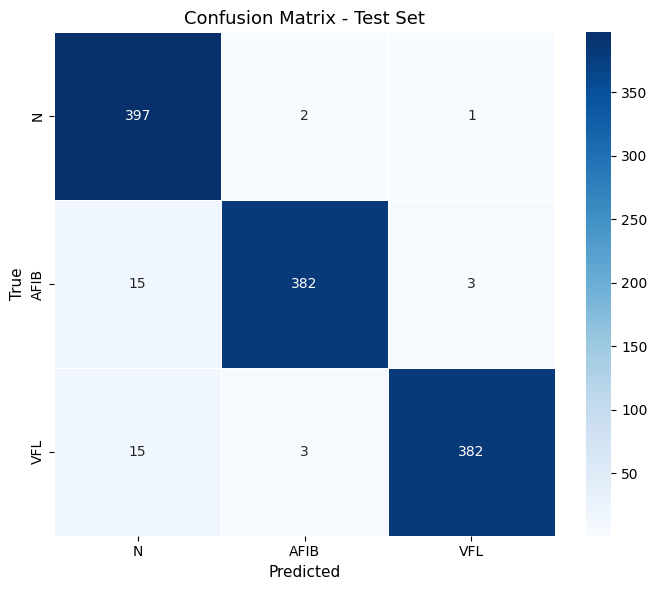

In [ ]:
# ===================== EVALUASI DECODER-ONLY (N, AFIB, VFL) =====================
import os, json, torch, numpy as np, pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

# ---------- KONFIGURASI ----------
# (Ganti path sesuai lingkungan Anda)
TEST_DIR    = r"/workspace/SPLIT_SLIDING_FINAL/test"
MODEL_PATH  = r"/workspace/HASIL_DECODER_KFOLD/Hasil_2/decoder_best.pt"
CONFIG_PATH = r"/workspace/HASIL_DECODER_KFOLD/Hasil_2/config.json"

LABEL_MAP   = {'N': 0, 'AFIB': 1, 'VFL': 2}      # urutan kelas final
IDX2LABEL   = ['N', 'AFIB', 'VFL']               # konsisten utk cm & tabel
MAX_LEN     = 512
BATCH_SIZE  = 16
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- LOAD KONFIGURASI MODEL ----------
with open(CONFIG_PATH, "r") as f:
    cfg = json.load(f)
D_MODEL  = cfg.get('d_model', 768)
N_HEAD   = cfg.get('n_head', 12)
N_LAYERS = cfg.get('n_layers', 12)

# ---------- UTILITAS DATA ----------
def signal_to_tensor(sig, target_len=MAX_LEN):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig) - 1, target_len).astype(int)
        sig = sig[idx]
    sig = (sig - sig.min()) / (sig.ptp() + 1e-8)
    return torch.tensor(sig, dtype=torch.float32)

def load_split_folder(data_dir, label_map):
    xs, ys = [], []
    for cls in os.listdir(data_dir):
        if cls not in label_map:        # hanya kelas yang diakui
            continue
        p = os.path.join(data_dir, cls)
        for fn in os.listdir(p):
            if fn.endswith(".npy"):
                arr = np.load(os.path.join(p, fn), allow_pickle=True)
                if isinstance(arr, np.ndarray) and arr.ndim == 1:
                    xs.append(signal_to_tensor(arr))
                    ys.append(label_map[cls])
    return xs, np.array(ys)

class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i): return self.signals[i], self.labels[i]

# ---------- ARSITEKTUR DECODER-ONLY ----------
class SimpleDecoderOnly(nn.Module):
    def __init__(self, d_model, nhead, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Linear(MAX_LEN, d_model)
        dec_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_layers)
        self.query = nn.Parameter(torch.randn(1, 1, d_model))
        self.classifier = nn.Linear(d_model, num_classes)
    def forward(self, x):
        x = self.embedding(x.unsqueeze(1))   # [B,1,MAX_LEN] -> [B,1,d_model]
        tgt = self.query.repeat(x.size(0), 1, 1)
        x = self.decoder(tgt, x).squeeze(1)  # [B,d_model]
        return self.classifier(x)

# ---------- LOAD DATA ----------
X_test_raw, y_test = load_split_folder(TEST_DIR, LABEL_MAP)
test_ds = ECGDataset(X_test_raw, y_test)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ---------- LOAD MODEL ----------
model = SimpleDecoderOnly(D_MODEL, N_HEAD, N_LAYERS, num_classes=len(LABEL_MAP)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ---------- INFERENSI ----------
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(yb.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# ---------- METRIK KESELURUHAN ----------
cm = confusion_matrix(all_labels, all_preds, labels=[LABEL_MAP[k] for k in IDX2LABEL])  # satu-satunya CM
acc = accuracy_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1m = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# Specificity per-kelas (berdasarkan CM)
def specificity_from_cm(cm, cls_index):
    TP = cm[cls_index, cls_index]
    FP = cm[:, cls_index].sum() - TP
    FN = cm[cls_index, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    return TN / (TN + FP + 1e-12)

spec_per_class = [specificity_from_cm(cm, i) for i in range(len(IDX2LABEL))]
spec_macro = float(np.mean(spec_per_class))

print("\n[HASIL UJI TEST]")
print(f"Akurasi     : {acc:.4f}")
print(f"Recall      : {rec:.4f}")
print(f"F1 Score    : {f1m:.4f}")
print(f"Spesifisitas: {spec_macro:.4f}")
print("Confusion Matrix:")
print(cm)

# ---------- TABEL METRIK PER-KELAS ----------
rows = []
for i, cls in enumerate(IDX2LABEL):
    # biner per kelas
    true_bin = (all_labels == i).astype(int)
    pred_bin = (all_preds  == i).astype(int)
    acc_i = accuracy_score(true_bin, pred_bin)
    rec_i = recall_score(true_bin, pred_bin, zero_division=0)
    f1_i  = f1_score(true_bin, pred_bin, zero_division=0)
    spec_i = spec_per_class[i]
    rows.append([cls, acc_i, rec_i, f1_i, spec_i])

df = pd.DataFrame(rows, columns=["Kelas","Akurasi","Recall","F1-Score","Spesifisitas"])
pd.set_option("display.float_format", lambda x: f"{x:.6f}")
print("\n", df)

# ---------- VISUALISASI (CM TUNGGAL) ----------
plt.figure(figsize=(6.5,5.5))
ax = sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=IDX2LABEL, yticklabels=IDX2LABEL,
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for t in ax.texts:  # teks diagonal putih
    r, c = [int(v) for v in t.get_position()]
    if r == c: t.set_color("white")
plt.tight_layout()

# simpan berkas di folder model
save_dir = os.path.dirname(MODEL_PATH)
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "confmat_test.png"))
df.to_csv(os.path.join(save_dir, "hasil_test_perkelas.csv"), index=False)
plt.show()